# Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
import mahotas
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D

# define Functions

In [17]:
def read_image(base_path, key, imgName):
    file_path = os.path.join(base_path, key[0] + "___" + key[1], imgName)

    img = cv2.imread(file_path)

    return img

In [18]:
# function returns a dictionary of images names sorted in this form {(plant, disease) : [img1, img2, ....]} where images stored in folders having names in this form plant___disease
def read_images_names(folder_path):
    
    # List all files in the dataset directory
    all_folder_names = os.listdir(folder_path)
    
    # store the names of training images depending on their folder names (plant___disease)
    images_names_dict = { (folder_name.split("___")[0], folder_name.split("___")[1]): os.listdir(os.path.join(folder_path, folder_name))
    for folder_name in all_folder_names }
    return images_names_dict

In [19]:
# n the number of images from each class
def sample_imgs_gray_resized(imgs_dir, images_names_dict, new_dimensions, n):
    
    label=[]
    imgs_sample=[]
    for key, values in images_names_dict.items():
        for imgName in values[0:n]:
            label.append(list(key))
            img = read_image(imgs_dir, key, imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_AREA)/255
            flattened_image = img.flatten()
            imgs_sample.append(flattened_image)
            
    return np.array(imgs_sample), np.array(label)

In [20]:
def read_all_imgs_gray_resized(imgs_dir, images_names_dict, new_dimensions):
    
    label=[]
    imgs_sample=[]
    for key, values in images_names_dict.items():
        for imgName in values:
            label.append(list(key))
            img = read_image(imgs_dir, key, imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_AREA)/255
            flattened_image = img.flatten()
            imgs_sample.append(flattened_image)
            
    return np.array(imgs_sample), np.array(label)

# Plant disease Classification with PCA + RandomForest

## load data (images)

In [5]:
# Directory containing the dataset
# Define paths relative to the script's location
current_dir = os.getcwd()
# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# train data dir
train_dir = os.path.join(parent_dir, 'plantReco/data/images/Plant_Diseases_Dataset/train')
valid_dir = os.path.join(parent_dir, 'plantReco/data/images/Plant_Diseases_Dataset/valid')


In [8]:
# images names from training folder 
train_images_names_dict = read_images_names(train_dir) 

In [9]:
# images from validation folder
valid_images_names_dict = read_images_names(valid_dir)

In [10]:
train_images_count =[len(values) for key, values in train_images_names_dict.items()]
valid_images_count =[len(values) for key, values in valid_images_names_dict.items()]

In [11]:
min(train_images_count)

3284

In [12]:
min(valid_images_count)

820

In [29]:
# size of the sample, images new dimension
n=3283
#n=10
new_dim = (64, 64)

In [30]:
# load a sample images from train folder
train_imgs, train_labels = sample_imgs_gray_resized(train_dir,train_images_names_dict, new_dim, n)

In [32]:
train_imgs.shape

(124754, 4096)

In [33]:
#read all images from valid folder
valid_imgs, valid_labels = read_all_imgs_gray_resized(imgs_dir=valid_dir, images_names_dict=valid_images_names_dict, new_dimensions=new_dim)

In [34]:
valid_imgs.shape

(35144, 4096)

## encode labels

In [38]:
# encoding for training and testing labels
plant_labels = train_labels[:,0]
disease_labels = train_labels[:,1]

# Initialize LabelEncoders
plant_encoder = LabelEncoder()
disease_encoder = LabelEncoder()

# Encode labels
plant_labels_encoded = plant_encoder.fit_transform(plant_labels)
disease_labels_encoded = disease_encoder.fit_transform(disease_labels)


In [39]:
# encode valid labels
plant_valid_labels = valid_labels[:,0]
disease_valid_labels = valid_labels[:,1]

# Transform the training and test labels
plant_valid_labels_encoded = plant_encoder.transform(plant_valid_labels)
disease_valid_labels_encoded = disease_encoder.transform(disease_valid_labels)



## PCA Transformation

In [40]:
# Initialize pca_ to reduce to 10 components
pca_n_comp = 10
pca = PCA(n_components=pca_n_comp  )

# Fit pca_ on the features and transform the data
train_imgs_pca = pca.fit_transform(train_imgs)

# Output the shapes of the original and reduced features
print("Original shape:", train_imgs.shape)
print("Reduced shape:", train_imgs_pca.shape)

Original shape: (124754, 4096)
Reduced shape: (124754, 10)


In [41]:
# do the same PCA transformation on valid data
valid_imgs_pca = pca.transform(valid_imgs)
# Output the shapes of the original and reduced features
print("Original shape:", valid_imgs.shape)
print("Reduced shape:", valid_imgs_pca.shape)

Original shape: (35144, 4096)
Reduced shape: (35144, 10)


## Split data and train the model

In [42]:
target_dict = {'plant_labels_encoded': plant_labels_encoded, 'disease_labels_encoded': disease_labels_encoded}

In [43]:
target_df = pd.DataFrame(target_dict)

In [45]:
target_df.tail()

,plant_labels_encoded,disease_labels_encoded
124749,13,18
124750,13,18
124751,13,18
124752,13,18
124753,13,18


In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_imgs_pca, target_df, test_size=0.2, random_state=42, shuffle=True)

In [47]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## First Validation using y_test

### validation for plant type detection

In [48]:
# Make predictions
y_pred = model.predict(X_test)

In [50]:
y_pred.shape

(24951, 2)

In [53]:
y_test.tail()

,plant_labels_encoded,disease_labels_encoded
115065,13,17
22400,2,14
90154,12,12
120370,13,19
118764,13,19


In [55]:
# Confusion Matrix
conf_mat_plant = confusion_matrix(y_test['plant_labels_encoded'], y_pred[:,0])

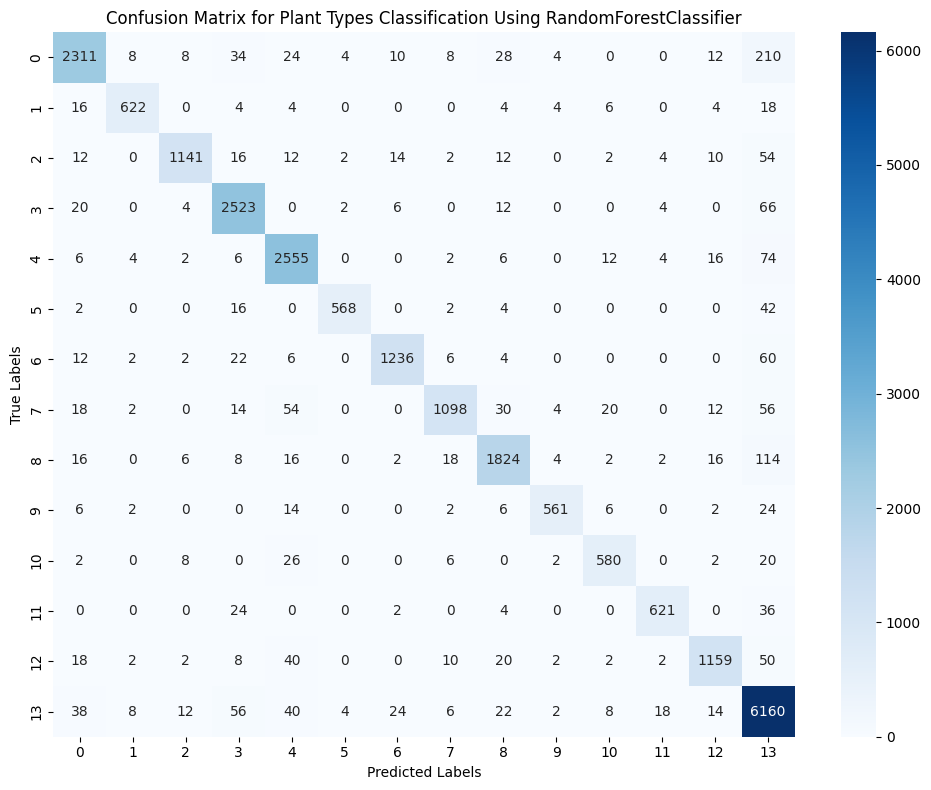

In [59]:
# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_plant, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Plant Types Classification Using RandomForestClassifier')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("plant_types_intrest_Confusion_Matrix_RandomForestClassifier_pca_10.png")
plt.show()

In [57]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test['plant_labels_encoded'], y_pred[:,0]))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2661
           1       0.96      0.91      0.93       682
           2       0.96      0.89      0.93      1281
           3       0.92      0.96      0.94      2637
           4       0.92      0.95      0.93      2687
           5       0.98      0.90      0.94       634
           6       0.96      0.92      0.93      1350
           7       0.95      0.84      0.89      1308
           8       0.92      0.90      0.91      2028
           9       0.96      0.90      0.93       623
          10       0.91      0.90      0.90       646
          11       0.95      0.90      0.93       687
          12       0.93      0.88      0.90      1315
          13       0.88      0.96      0.92      6412

    accuracy                           0.92     24951
   macro avg       0.94      0.91      0.92     24951
weighted avg       0.92      0.92      0.92     24951



### validation for disease type detection

In [58]:
# Confusion Matrix
conf_mat_disease = confusion_matrix(y_test['disease_labels_encoded'], y_pred[:,1])

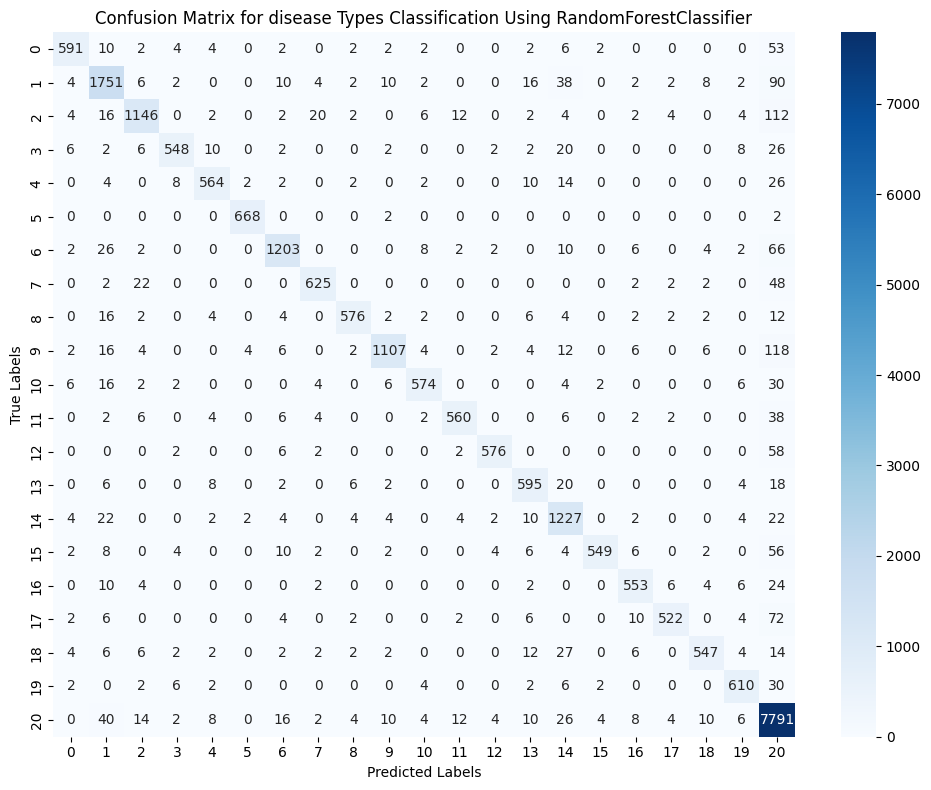

In [60]:
# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_disease, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for disease Types Classification Using RandomForestClassifier')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("disease_types_intrest_Confusion_Matrix_RandomForestClassifier_pca_10.png")
plt.show()

In [61]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test['disease_labels_encoded'], y_pred[:,1]))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       682
           1       0.89      0.90      0.90      1949
           2       0.94      0.86      0.89      1338
           3       0.94      0.86      0.90       634
           4       0.92      0.89      0.91       634
           5       0.99      0.99      0.99       672
           6       0.94      0.90      0.92      1333
           7       0.94      0.89      0.91       703
           8       0.95      0.91      0.93       634
           9       0.96      0.86      0.91      1293
          10       0.94      0.88      0.91       652
          11       0.94      0.89      0.91       632
          12       0.97      0.89      0.93       646
          13       0.87      0.90      0.88       661
          14       0.86      0.93      0.90      1313
          15       0.98      0.84      0.90       655
          16       0.91      0.91      0.91       611
    

## Second validation using data from valid folder

In [62]:
# Make predictions
y_pred_valid = model.predict(valid_imgs_pca)

### validation for plant type detection

In [63]:
# Confusion Matrix
conf_mat_plant_valid = confusion_matrix(plant_valid_labels_encoded, y_pred_valid[:,0])

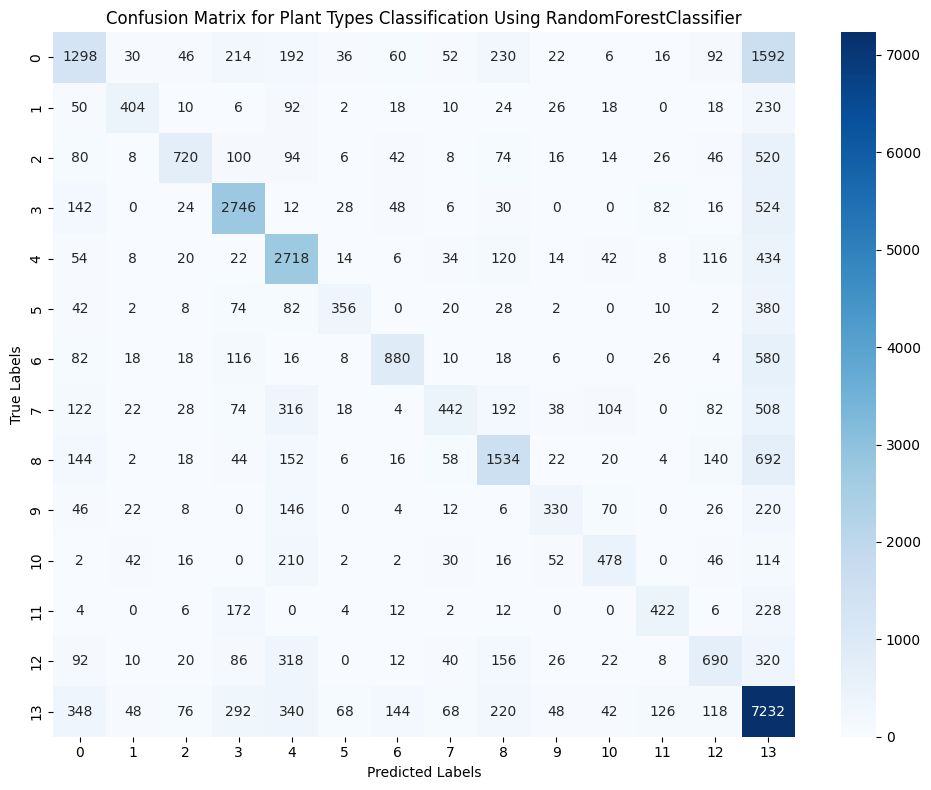

In [64]:
# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_plant_valid, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Plant Types Classification Using RandomForestClassifier')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("plant_types_intrest_Confusion_Matrix_RandomForestClassifier_pca_10_valid.png")
plt.show()

In [65]:
# Classification Report
print("Classification Report:")
print(classification_report(plant_valid_labels_encoded, y_pred_valid[:,0]))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.33      0.41      3886
           1       0.66      0.44      0.53       908
           2       0.71      0.41      0.52      1754
           3       0.70      0.75      0.72      3658
           4       0.58      0.75      0.66      3610
           5       0.65      0.35      0.46      1006
           6       0.71      0.49      0.58      1782
           7       0.56      0.23      0.32      1950
           8       0.58      0.54      0.56      2852
           9       0.55      0.37      0.44       890
          10       0.59      0.47      0.52      1010
          11       0.58      0.49      0.53       868
          12       0.49      0.38      0.43      1800
          13       0.53      0.79      0.64      9170

    accuracy                           0.58     35144
   macro avg       0.60      0.49      0.52     35144
weighted avg       0.58      0.58      0.56     35144



### validation for disease type detection

In [68]:
# Confusion Matrix
conf_mat_disease_valid = confusion_matrix(disease_valid_labels_encoded, y_pred_valid[:,1])

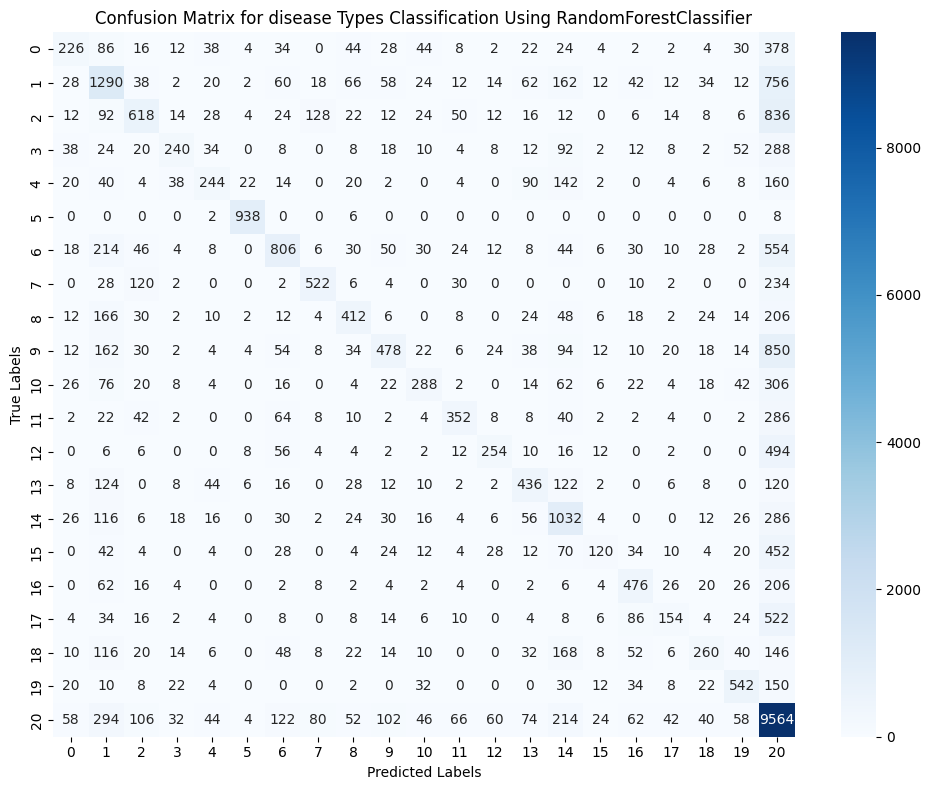

In [69]:
# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_disease_valid, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for disease Types Classification Using RandomForestClassifier')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("disease_types_intrest_Confusion_Matrix_RandomForestClassifier_pca_10_valid.png")
plt.show()

In [70]:
# Classification Report
print("Classification Report:")
print(classification_report(disease_valid_labels_encoded, y_pred_valid[:,1]))

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.22      0.30      1008
           1       0.43      0.47      0.45      2724
           2       0.53      0.32      0.40      1938
           3       0.56      0.27      0.37       880
           4       0.47      0.30      0.37       820
           5       0.94      0.98      0.96       954
           6       0.57      0.42      0.48      1930
           7       0.66      0.54      0.59       960
           8       0.51      0.41      0.45      1006
           9       0.54      0.25      0.34      1896
          10       0.49      0.31      0.38       940
          11       0.58      0.41      0.48       860
          12       0.59      0.29      0.39       888
          13       0.47      0.46      0.47       954
          14       0.43      0.60      0.50      1710
          15       0.49      0.14      0.22       872
          16       0.53      0.55      0.54       870
    